# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [75]:
#Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [76]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [77]:
#your code here
spaceship['cabin_new'] = spaceship['Cabin'].str[0]

In [78]:
spaceship['Destination'].unique()
# one hot encoding for cabin_new, Homeplanet and Destination
cols_for_dummies = spaceship[['cabin_new', 'Destination', 'HomePlanet']]
spaceship_transformed = pd.get_dummies(cols_for_dummies, drop_first=True)
spaceship.drop(columns=['Cabin','cabin_new', 'Destination', 'HomePlanet','Name'],inplace=True)
spaceship_final = pd.merge(left=spaceship,
                              right=spaceship_transformed,
                              left_index=True,
                              right_index=True)
spaceship_final


,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,cabin_new_C,cabin_new_D,cabin_new_E,cabin_new_F,cabin_new_G,cabin_new_T,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,...,False,False,False,False,False,False,False,True,True,False
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,...,False,False,False,True,False,False,False,True,False,False
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,...,False,False,False,False,False,False,False,True,True,False
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,...,False,False,False,False,False,False,False,True,True,False
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,...,False,False,False,False,False,False,False,False,True,False
8689,9278_01,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,...,False,False,False,False,True,False,True,False,False,False
8690,9279_01,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,...,False,False,False,False,True,False,False,True,False,False
8691,9280_01,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,...,False,False,True,False,False,False,False,False,True,False


In [79]:
spaceship_final.isna().sum()
spaceship_final.dropna(inplace=True)

**Perform Train Test Split**

In [80]:
#your code here
features = spaceship_final.drop(columns='Transported')
target = spaceship_final['Transported']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [81]:
X_test

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_new_B,cabin_new_C,cabin_new_D,cabin_new_E,cabin_new_F,cabin_new_G,cabin_new_T,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Europa,HomePlanet_Mars
5012,5354_02,False,28.0,False,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,True,False,True
629,0657_01,False,28.0,False,0.0,863.0,0.0,17.0,0.0,False,False,False,False,True,False,False,False,True,False,False
8673,9256_01,True,28.0,False,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,True,False,False,True,False,False
5582,5946_01,False,19.0,False,300.0,5.0,642.0,0.0,0.0,False,False,False,True,False,False,False,False,True,False,True
5144,5492_01,False,23.0,False,0.0,551.0,59.0,720.0,14.0,False,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3674,3946_01,False,37.0,False,14.0,0.0,91.0,1203.0,0.0,False,False,False,False,True,False,False,False,True,False,True
2678,2869_01,True,61.0,False,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,True,False,True,False,False,False
5861,6207_01,False,31.0,False,915.0,0.0,1313.0,370.0,0.0,False,False,False,False,True,False,False,False,True,False,True
5921,6281_01,False,38.0,False,20.0,0.0,751.0,0.0,2.0,False,False,False,False,False,True,False,False,True,False,False


In [82]:
scaler = MinMaxScaler()
# Fit and transform the X_train data and only transform the X_test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [83]:
X_test_scaled

array([[0.57689514, 0.        , 0.35443038, ..., 1.        , 0.        ,
        1.        ],
       [0.07069727, 0.        , 0.35443038, ..., 1.        , 0.        ,
        0.        ],
       [0.99741351, 1.        , 0.35443038, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.66882207, 0.        , 0.39240506, ..., 1.        , 0.        ,
        1.        ],
       [0.67679707, 0.        , 0.48101266, ..., 1.        , 0.        ,
        0.        ],
       [0.65632072, 1.        , 0.35443038, ..., 1.        , 0.        ,
        0.        ]])

In [84]:
def train_model(model_instance):
    model_instance.fit(X_train_scaled, y_train)
    return model_instance

def test_model(trained_model):
    pred = trained_model.predict(X_test_scaled)
    print(trained_model)
    print("Accuracy score", trained_model.score(X_test_scaled, y_test))
    print("Precision score", precision_score(y_test, pred))
    print("Recall score", recall_score(y_test, pred))
    print("F1 score", f1_score(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
    # standalone functions need y-test and predictions. WHen we're calling the score from the model, we pass the features and the y-test

**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [85]:
#your code here
bagging_reg = BaggingClassifier(DecisionTreeClassifier(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)

In [86]:
forest = RandomForestClassifier(n_estimators=100,
                             max_depth=20)

In [87]:
ada_reg = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                            n_estimators=100)

In [88]:
gb_reg = GradientBoostingClassifier(max_depth=20,n_estimators=100)

In [89]:
models = [bagging_reg, forest, ada_reg, gb_reg]
trained_models = []
for model in models:
    trained_models.append(train_model(model))

trained_models

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   max_samples=1000, n_estimators=100),
 RandomForestClassifier(max_depth=20),
 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                    n_estimators=100),
 GradientBoostingClassifier(max_depth=20)]

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                  max_samples=1000, n_estimators=100)
Accuracy score 0.7960027567195038
Precision score 0.8081081081081081
Recall score 0.7952127659574468
F1 score 0.8016085790884718


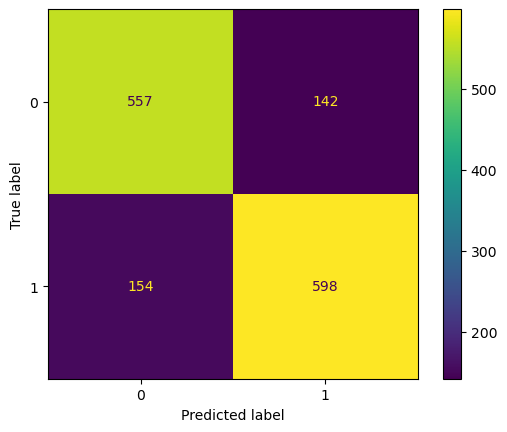

RandomForestClassifier(max_depth=20)
Accuracy score 0.7877325982081324
Precision score 0.8135593220338984
Recall score 0.7659574468085106
F1 score 0.7890410958904109


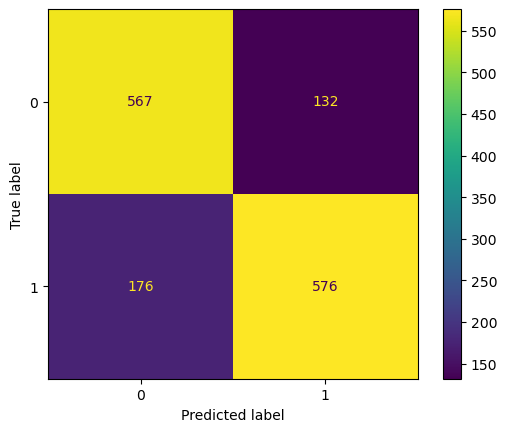

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   n_estimators=100)
Accuracy score 0.7767057201929704
Precision score 0.7972222222222223
Recall score 0.7632978723404256
F1 score 0.779891304347826


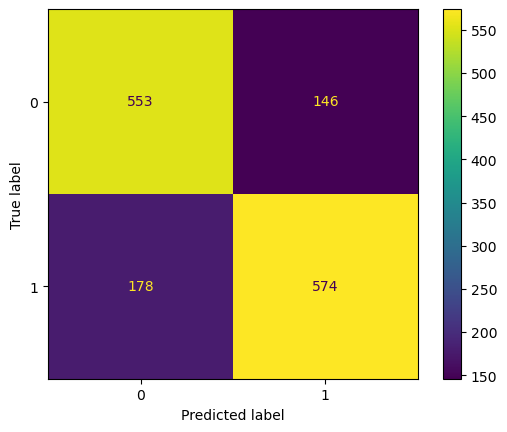

GradientBoostingClassifier(max_depth=20)
Accuracy score 0.7691247415575465
Precision score 0.797432239657632
Recall score 0.7433510638297872
F1 score 0.7694425326909842


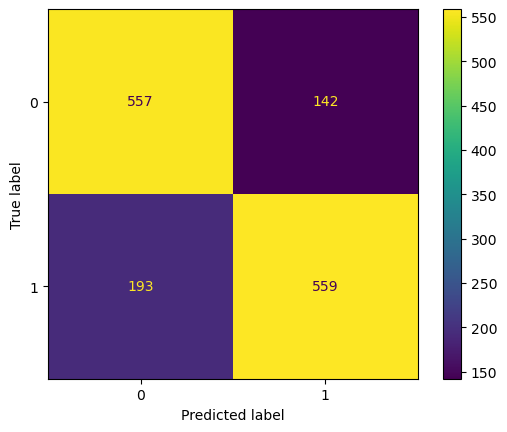

In [90]:
for trained_model in trained_models:
    test_model(trained_model)

- Random Forests

In [91]:
#your code here

- Gradient Boosting

In [92]:
#your code here

- Adaptive Boosting

In [93]:
#your code here

Which model is the best and why?

In [94]:
#comment here